In [1]:
import numpy as np
from os.path import abspath, exists
from scipy import sparse
import scipy
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
# Functions to import nodes and edges files. Code below is adapted from test_football demo code.
def import_nodes_graph():
    # read the graph from txt files
    f_path = abspath("nodes.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            nodes_lines = [line.split()[0] for line in graph_file]
    return np.array(nodes_lines).astype(int)


def import_labels_graph():
    # read the true labels from txt files
    f_path = abspath("nodes.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            true_label = [line.split()[2] for line in graph_file]
    return np.array(true_label).astype(int)


def import_edges_graph():
    # read the graph from txt file
    f_path = abspath("edges.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            lines = [line.split() for line in graph_file]
    return np.array(lines).astype(int)

In [3]:
np.set_printoptions(threshold=np.inf)
nodes = import_nodes_graph()

labels = import_labels_graph()
# print(f"{len(labels)}")

edges = import_edges_graph()
edges.shape
# print(f"{edges}")

(19090, 2)

In [4]:
def spectral_clusters(k):
    # The following codes are adapted from test_football demo code.
    i = edges[:, 0] - 1  # Take the first column and decrement by 1
    j = edges[:, 1] - 1  # Take the second column and decrement by 1
    n = len(nodes)

    v = np.ones(edges.shape[0])

    # Create adjacency matrix
    A = sparse.coo_matrix((v, (i, j)), shape=(n, n))
    A = A + A.T
    # There are duplicative edges resulting in values greater than 1. Replace with 1.
    A[A > 0] = 1
    A = sparse.csc_matrix.todense(A)  # Convert to dense matrix

    # Remove nodes that have no connections
    degree = np.sum(np.array(A), axis=0).flatten()
    connected_nodes = degree > 0
    updated_edges = A[connected_nodes][:, connected_nodes]

    # Filter the labels
    filtered_labels = labels[connected_nodes]

    D = np.diag(1 / np.sqrt(np.sum(updated_edges, axis=1)).A1)
    L = D @ updated_edges @ D
    L = np.array(L)  # ## covert to array

    # The following code is adapted from test_football demo code.
    # Eigendecomposition
    v, x = scipy.linalg.eigh(L)

    idx_sorted = np.argsort(v)

    # Obtain the largest eigenvectors
    x = x[:, idx_sorted[-k:]]
    x = x / np.repeat(np.sqrt(np.sum(x * x, axis=1).reshape(-1, 1)), k, axis=1)

    kmeans = KMeans(n_clusters=k).fit(x)
    c_idx = kmeans.labels_

    return (c_idx, len(updated_edges), filtered_labels)

In [5]:
def find_maj_label(clusters, n, filtered_labels):
    majority_labels = {}
    mismatch_rate = {}
    weight = {}

    for cluster in np.unique(clusters):
        # Find indices of each cluster
        indx = np.where(clusters == cluster)[0]
        # Get the true labels associated with the nodes that are grouped in the same cluster
        cluster_true_labels = filtered_labels[indx]
        # Count how many 0s and 1s true labels that are in the same cluster
        count_labels = Counter(cluster_true_labels)

        # Get the majority label based on the maximum count
        maj_label = max(
            count_labels, key=count_labels.get
        )  # Code adapted from https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-80.php

        mismatch_val = len(indx) - count_labels[maj_label]

        # Compute overall mismatch rate (not weighted) = total mismatch / # nodes in the cluster
        mismatch_rate[cluster] = mismatch_val / len(indx)

        # Compute weight
        weight[cluster] = len(indx) / n


    return majority_labels, mismatch_rate, weight

In [6]:
k = [2, 5, 10, 30, 50]

np.random.seed(2)

# Store overall weighted average mismatch rates for all k values
mismatch_arr = np.zeros(len(k))  

# Store mismatch rates by group within the cluster
mismatch_group = []

for indx, k_val in enumerate(k):
    clusters, n, filtered_labels = spectral_clusters(k_val)
    majority_labels, mismatch_rate, weight = find_maj_label(clusters, n, filtered_labels)
    overall_mismatch = sum([mismatch_rate[j] * weight[j] for j in range(k_val)])
    mismatch_arr[indx] = np.round(overall_mismatch, 4)
    print(f"{mismatch_rate = }")

    mismatch_group.append(list(mismatch_rate.values()))


mismatch_mat = np.array([np.pad(arr, (0, max(k) - len(arr)), 'constant', constant_values=0) for arr in mismatch_group])
mismatch_mat = np.vstack(np.round(mismatch_mat,2)).T

print(f"{mismatch_mat = }")
print(f"{mismatch_arr = }")

c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


mismatch_rate = {np.int32(0): 0.4795417348608838, np.int32(1): 0.0}


c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


mismatch_rate = {np.int32(0): 0.02197802197802198, np.int32(1): 0.02707275803722504, np.int32(2): 0.45454545454545453, np.int32(3): 0.2, np.int32(4): 0.4}


c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


mismatch_rate = {np.int32(0): 0.023474178403755867, np.int32(1): 0.02203856749311295, np.int32(2): 0.1875, np.int32(3): 0.45714285714285713, np.int32(4): 0.017543859649122806, np.int32(5): 0.47058823529411764, np.int32(6): 0.02857142857142857, np.int32(7): 0.0, np.int32(8): 0.03225806451612903, np.int32(9): 0.024128686327077747}


c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


mismatch_rate = {np.int32(0): 0.01282051282051282, np.int32(1): 0.024390243902439025, np.int32(2): 0.022222222222222223, np.int32(3): 0.07272727272727272, np.int32(4): 0.02702702702702703, np.int32(5): 0.13333333333333333, np.int32(6): 0.06382978723404255, np.int32(7): 0.08695652173913043, np.int32(8): 0.05714285714285714, np.int32(9): 0.024096385542168676, np.int32(10): 0.08791208791208792, np.int32(11): 0.3783783783783784, np.int32(12): 0.0, np.int32(13): 0.10638297872340426, np.int32(14): 0.0, np.int32(15): 0.2, np.int32(16): 0.09090909090909091, np.int32(17): 0.045454545454545456, np.int32(18): 0.16666666666666666, np.int32(19): 0.031914893617021274, np.int32(20): 0.0, np.int32(21): 0.2222222222222222, np.int32(22): 0.04, np.int32(23): 0.0, np.int32(24): 0.0, np.int32(25): 0.14634146341463414, np.int32(26): 0.0196078431372549, np.int32(27): 0.023809523809523808, np.int32(28): 0.2, np.int32(29): 0.0}
mismatch_rate = {np.int32(0): 0.0, np.int32(1): 0.0, np.int32(2): 0.021276595744680

c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Part 2

c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\jm121\miniconda3\envs\general_env\Lib\site-packages\sklearn\cluster\_kmea

Text(0, 0.5, 'The Overall Mismatch Rate')

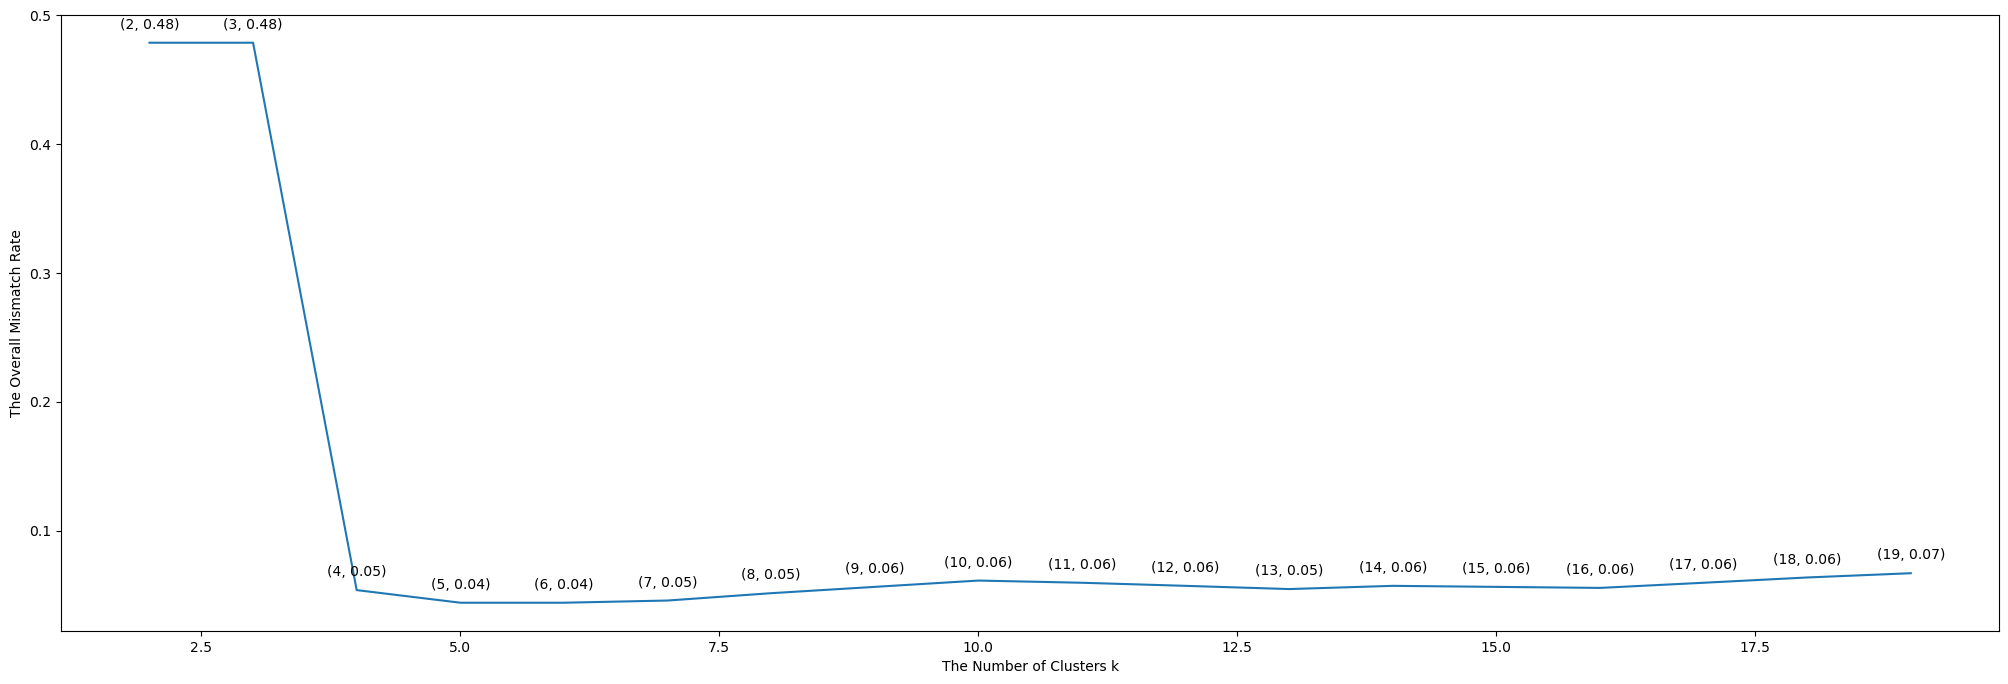

In [7]:
# Test different k values
k = np.arange(2, 20)

np.random.seed(124)

mismatch_arr = np.zeros(len(k))

for indx, k_val in enumerate(k):
    clusters, n, filtered_labels = spectral_clusters(k_val)
    majority_labels, mismatch_rate, weight = find_maj_label(clusters, n, filtered_labels)
    overall_mismatch = sum([mismatch_rate[j] * weight[j] for j in range(k_val)])
    mismatch_arr[indx] = np.round(overall_mismatch, 4)

plt.figure(figsize=(25, 8))
plt.plot(k, mismatch_arr)

# Add annotation. Adapted the annotation code from https://www.geeksforgeeks.org/line-chart-in-matplotlib-python/#
for i, (k_val, mismatch_val) in enumerate(zip(k, mismatch_arr)):
    plt.annotate(
        f"{k[i].item(), round(mismatch_arr[i].item(),2)}",
        (k_val, mismatch_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.xlabel("The Number of Clusters k")
plt.ylabel("The Overall Mismatch Rate")

In [8]:
min_indx = np.argmin(mismatch_arr)
min_mismatch = mismatch_arr[min_indx]
print(f"When there are {k[min_indx]} clusters, the minimum overall mismatch rate is {min_mismatch}")

When there are 5 clusters, the minimum overall mismatch rate is 0.0441
